In [1]:
import os
import sys
import json
from datetime import datetime
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor

In [2]:
# Add the `src` folder to the Python path
current_dir = os.getcwd() 
src_path = os.path.join(current_dir, 'src')
sys.path.append(src_path)
import utilities as util

# Add 'src/task1a' and 'src/task1c' folders to the Python path
sys.path.append(os.path.abspath("../src/task1a"))
sys.path.append(os.path.abspath("../src/task1c"))
import environment_gym as env_gym
import environment_gym_rs2 as env_gym_rs2

# Load the TensorBoard extension
# %load_ext tensorboard

## DQN Baseline Model

### Train Baseline Model

In [3]:
# Initialize and vectorize the environment
env = env_gym.TrafficEnvironment()
check_env(env, warn=True)
eval_env = Monitor(env_gym.TrafficEnvironment())

# Set up log directory
log_dir = "./logs/dqn_baseline_model/"
os.makedirs(log_dir + "best_model/", exist_ok=True)
os.makedirs(log_dir + "final_model/", exist_ok=True)

# Define the DQN model with MlpPolicy (a policy network that works well with continuous environments)
model = DQN(policy = "MlpPolicy",
            env = env, 
            verbose = 1,
           )

# Set up evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir + "best_model/",
    log_path=log_dir + "results/",
    eval_freq=1000,  # Evaluate the model every 1000 steps
    deterministic=True,
    render=False
)

# Train the DQN model
total_timesteps = 100000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

# Save the final model
final_model_path = log_dir + "final_model"
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Eval num_timesteps=1000, episode_reward=-10974.00 +/- 12315.60
Episode length: 1497.40 +/- 1231.56
----------------------------------
| eval/               |          |
|    mean_ep_length   | 1.5e+03  |
|    mean_reward      | -1.1e+04 |
| rollout/            |          |
|    exploration_rate | 0.905    |
| time/               |          |
|    total_timesteps  | 1000     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 8.54     |
|    n_updates        | 224      |
----------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-13156.00 +/- 13677.55
Episode length: 1715.60 +/- 1367.76
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 1.72e+03  |
|    mean_reward      | -1.32e+04 |
| rollout/            |           |
|    exploration_rate | 0.81      |
| time/       

### Test Baseline Model

In [4]:
# Load the best baseline model
log_dir = "./logs/dqn_baseline_model/"
model_path = log_dir + 'best_model/best_model.zip'
model = DQN.load(model_path)

# Create test environment
env_test = env_gym.TrafficEnvironment()

In [5]:
# Test the model
num_episodes = 1000
file_name = 'dqn_baseline_best_model_test_log.json'
rewards, timesteps = util.test_model(model=model, env=env_test, num_episodes=num_episodes, output_file=file_name)

Average reward of 1000 episodes is -10384.
Average timesteps of 1000 episodes is 1065.


### Analysis of Baseline Model

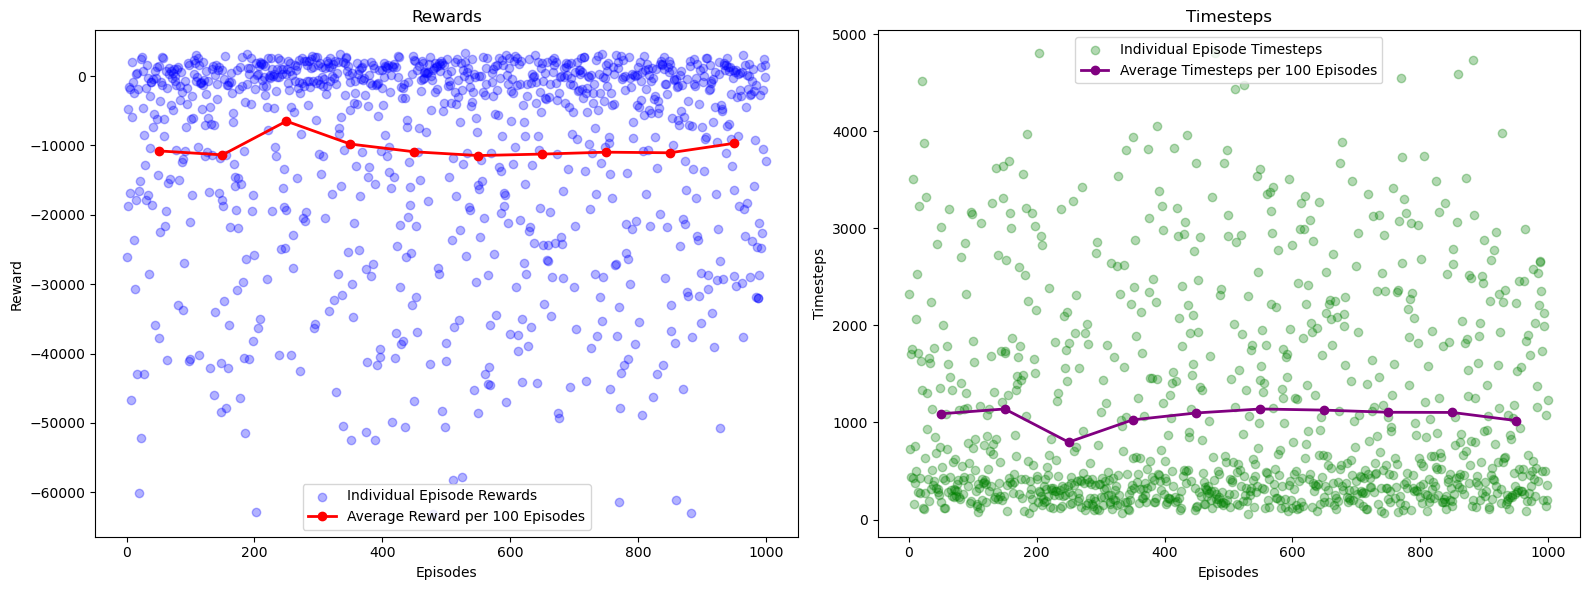

In [6]:
util.plot_test_dotplots(rewards=rewards, timesteps=timesteps, interval=100)

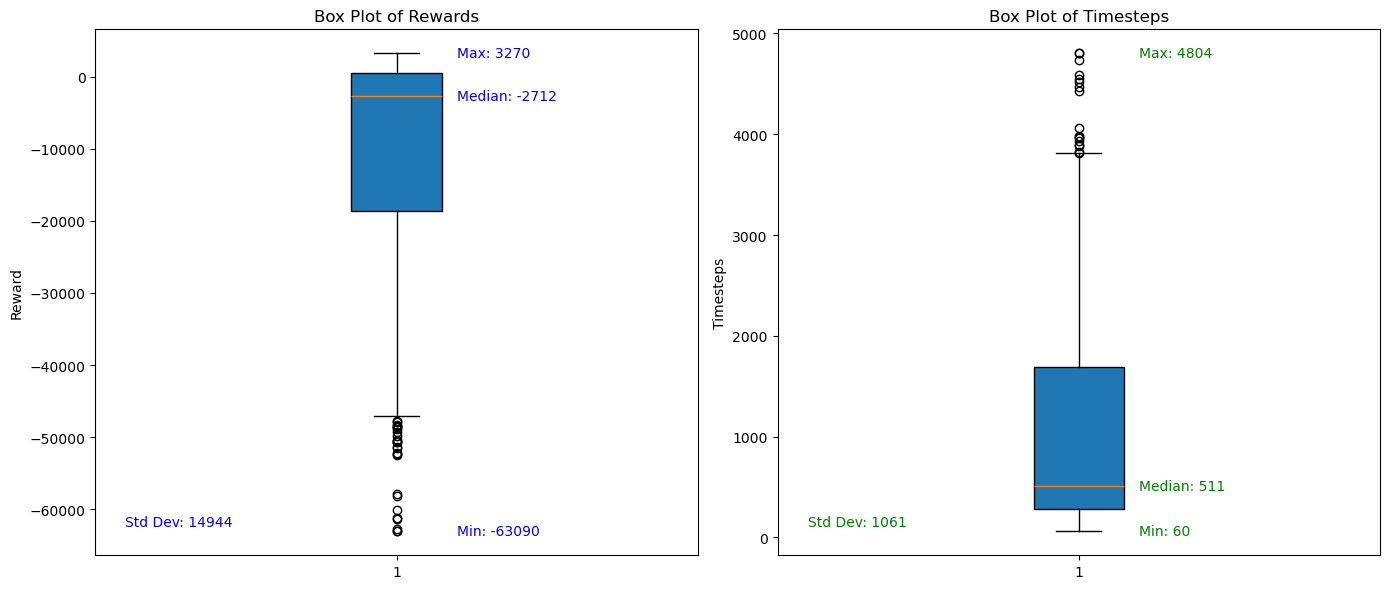

In [7]:
file_name = 'dqn_baseline_best_model_test_log.json'
util.plot_test_boxplots(json_file=file_name)

In [8]:
util.calculate_action_percentages(log_file=file_name)

Total actions across 1000 episodes: 1064711
Action -1: 70.2%
Action 0: 29.8%
Action 1: 0.0%


## Analysis of Clerance Rates

In [9]:
util.calculate_clearance_rate_percentages(log_file=file_name)

Total timesteps across 1000 episodes (including initial states): 1065711
Lane 1:
  77.8% of timesteps had a clearance rate less than 5
  88.5% of timesteps had a clearance rate less than 10
Lane 2:
  77.3% of timesteps had a clearance rate less than 5
  88.0% of timesteps had a clearance rate less than 10
Lane 3:
  77.1% of timesteps had a clearance rate less than 5
  87.6% of timesteps had a clearance rate less than 10
Lane 4:
  77.1% of timesteps had a clearance rate less than 5
  87.4% of timesteps had a clearance rate less than 10
Lane 5:
  77.5% of timesteps had a clearance rate less than 5
  87.4% of timesteps had a clearance rate less than 10


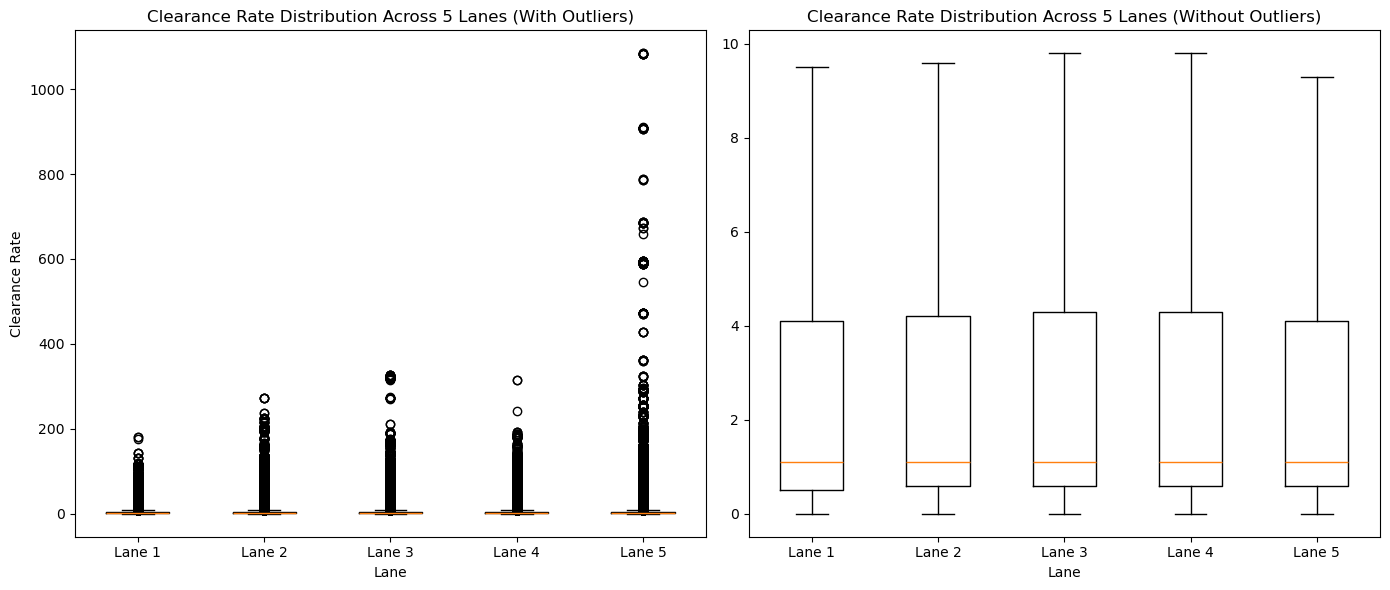

In [10]:
util.plot_clearance_rate_boxplots(log_file=file_name)

In [11]:
import optuna
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
import os

def optimize_dqn(trial):
    # Define hyperparameters to search
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    buffer_size = trial.suggest_categorical('buffer_size', [50000, 100000, 200000])
    learning_starts = trial.suggest_categorical('learning_starts', [1000, 5000, 10000])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    gamma = trial.suggest_float('gamma', 0.8, 0.999)
    
    # Initialize environment and wrap it for monitoring
    env = Monitor(env_gym.TrafficEnvironment())
    
    # Initialize the DQN model with suggested hyperparameters
    model = DQN(
        "MlpPolicy",
        env,
        learning_rate=learning_rate,
        buffer_size=buffer_size,
        learning_starts=learning_starts,
        batch_size=batch_size,
        gamma=gamma,
        verbose=0
    )
    
    # Train model for a fixed number of timesteps
    model.learn(total_timesteps=20000)
    
    # Evaluate the model and return the mean reward for optimization
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
    return mean_reward

# Set up Optuna study with early stopping
study = optuna.create_study(study_name="DQN_Optimization", direction="maximize")


# Define an early stopping callback
def stop_early(study, trial):
    # Customize your early stopping condition here
    # For example, if the best trial reward surpasses 200, stop further trials
    if trial.number >= 10 and study.best_value > 200:
        return True
    return False

# Run the optimization with the early stopping callback
study.optimize(optimize_dqn, n_trials=50, callbacks=[stop_early])

# Display best parameters
print("Best hyperparameters:", study.best_params)

# Train a final model with the best parameters
best_params = study.best_params
final_env = Monitor(env_gym.TrafficEnvironment())

final_model = DQN(
    "MlpPolicy",
    final_env,
    **best_params,
    verbose=1
)

# Use the same evaluation callback as in your original code
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir + "best_model_optuna/",
    log_path=log_dir + "results_optuna/",
    eval_freq=1000,
    deterministic=True,
    render=False
)

# Train the model with optimized hyperparameters
final_model.learn(total_timesteps=total_timesteps, callback=eval_callback)

# Save the final model
final_model_path = log_dir + "final_model_optuna"
final_model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

[I 2024-11-16 14:55:58,966] A new study created in memory with name: DQN_Optimization
[I 2024-11-16 14:56:22,096] Trial 0 finished with value: -8904.0 and parameters: {'learning_rate': 3.886523281435665e-05, 'buffer_size': 200000, 'learning_starts': 10000, 'batch_size': 32, 'gamma': 0.8365600525520139}. Best is trial 0 with value: -8904.0.
[I 2024-11-16 14:56:42,006] Trial 1 finished with value: 1112.0 and parameters: {'learning_rate': 0.00012342827492703329, 'buffer_size': 50000, 'learning_starts': 10000, 'batch_size': 128, 'gamma': 0.9424518877764932}. Best is trial 1 with value: 1112.0.
[I 2024-11-16 14:57:11,321] Trial 2 finished with value: -3040.0 and parameters: {'learning_rate': 0.0003461620912160732, 'buffer_size': 50000, 'learning_starts': 5000, 'batch_size': 32, 'gamma': 0.9634334560460782}. Best is trial 1 with value: 1112.0.
[I 2024-11-16 14:57:52,639] Trial 3 finished with value: -19190.0 and parameters: {'learning_rate': 0.00010835984312058432, 'buffer_size': 200000, 'le

Best hyperparameters: {'learning_rate': 5.572634757385313e-05, 'buffer_size': 50000, 'learning_starts': 10000, 'batch_size': 128, 'gamma': 0.979051532437525}
Using cuda device
Wrapping the env in a DummyVecEnv.
Eval num_timesteps=1000, episode_reward=-4843.00 +/- 6158.93
Episode length: 884.20 +/- 615.76
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 884       |
|    mean_reward      | -4.84e+03 |
| rollout/            |           |
|    exploration_rate | 0.905     |
| time/               |           |
|    total_timesteps  | 1000      |
-----------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-9478.00 +/- 14476.33
Episode length: 1347.80 +/- 1447.63
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 1.35e+03  |
|    mean_reward      | -9.48e+03 |
| rollout/            |           |
|    exploration_rate | 0.81      |
| time/               |           

In [12]:
# Load the best optuna model
log_dir = "./logs/dqn_baseline_model/"
model_path = log_dir + 'final_model_optuna.zip'
model = DQN.load(model_path)

# Create test environment
env_test = env_gym.TrafficEnvironment()

In [13]:
# Test the model
num_episodes = 1000
file_name = 'dqn_baseline_best_optuna_model_test_log.json'
rewards, timesteps = util.test_model(model=model, env=env_test, num_episodes=num_episodes, output_file=file_name)

Average reward of 1000 episodes is -5155.
Average timesteps of 1000 episodes is 912.


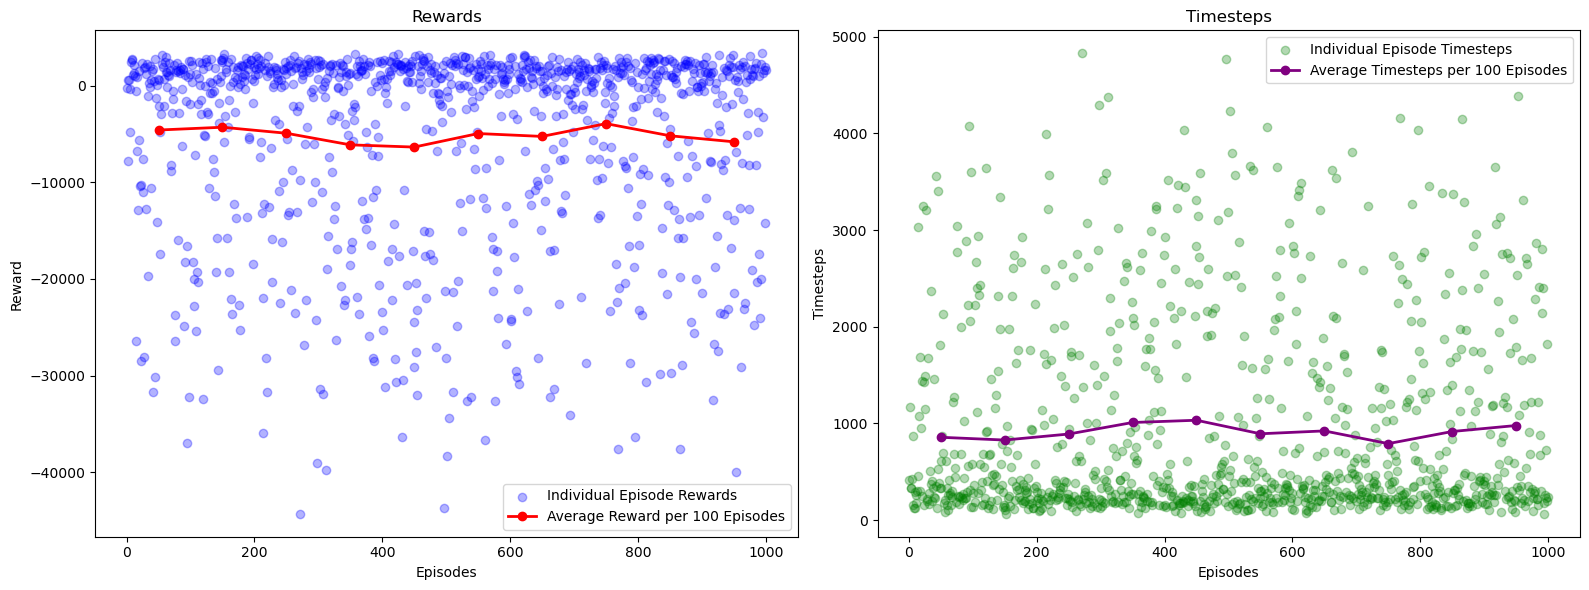

In [14]:
util.plot_test_dotplots(rewards=rewards, timesteps=timesteps, interval=100)

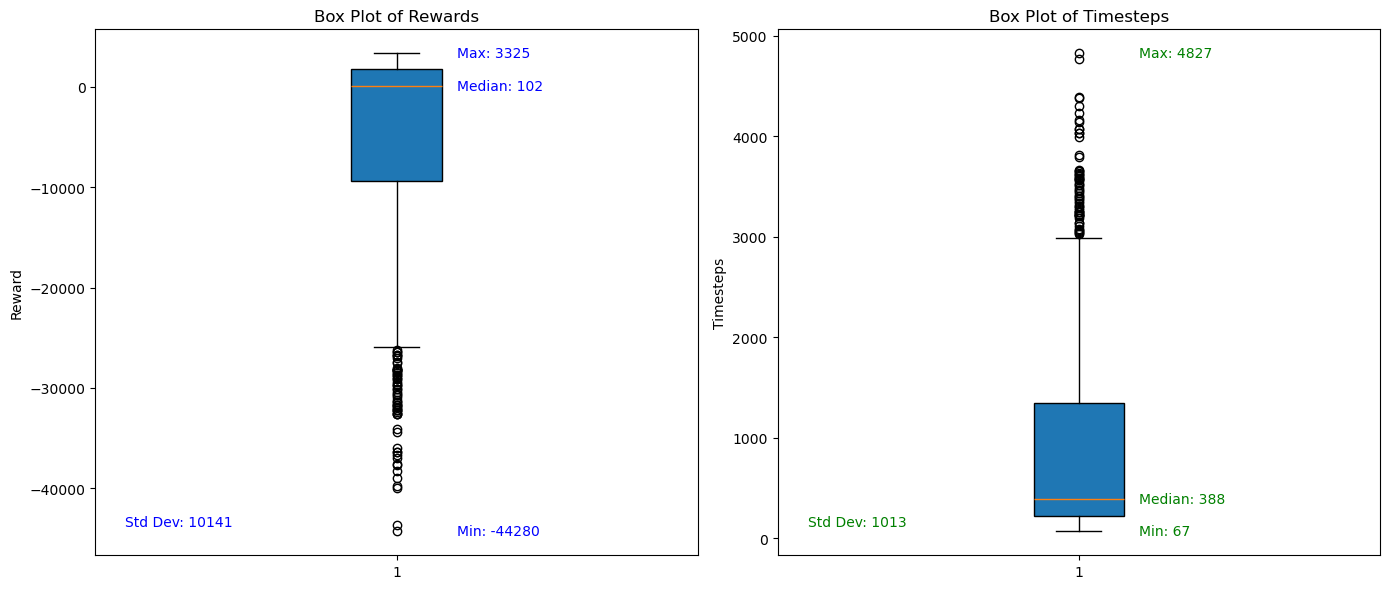

In [15]:
file_name = 'dqn_baseline_best_optuna_model_test_log.json'
util.plot_test_boxplots(json_file=file_name)

In [16]:
util.calculate_action_percentages(log_file=file_name)

Total actions across 1000 episodes: 912420
Action -1: 0.1%
Action 0: 99.3%
Action 1: 0.6%


In [17]:
util.calculate_clearance_rate_percentages(log_file=file_name)

Total timesteps across 1000 episodes (including initial states): 913420
Lane 1:
  76.3% of timesteps had a clearance rate less than 5
  86.8% of timesteps had a clearance rate less than 10
Lane 2:
  75.8% of timesteps had a clearance rate less than 5
  86.7% of timesteps had a clearance rate less than 10
Lane 3:
  75.6% of timesteps had a clearance rate less than 5
  86.8% of timesteps had a clearance rate less than 10
Lane 4:
  75.8% of timesteps had a clearance rate less than 5
  86.9% of timesteps had a clearance rate less than 10
Lane 5:
  76.2% of timesteps had a clearance rate less than 5
  87.1% of timesteps had a clearance rate less than 10


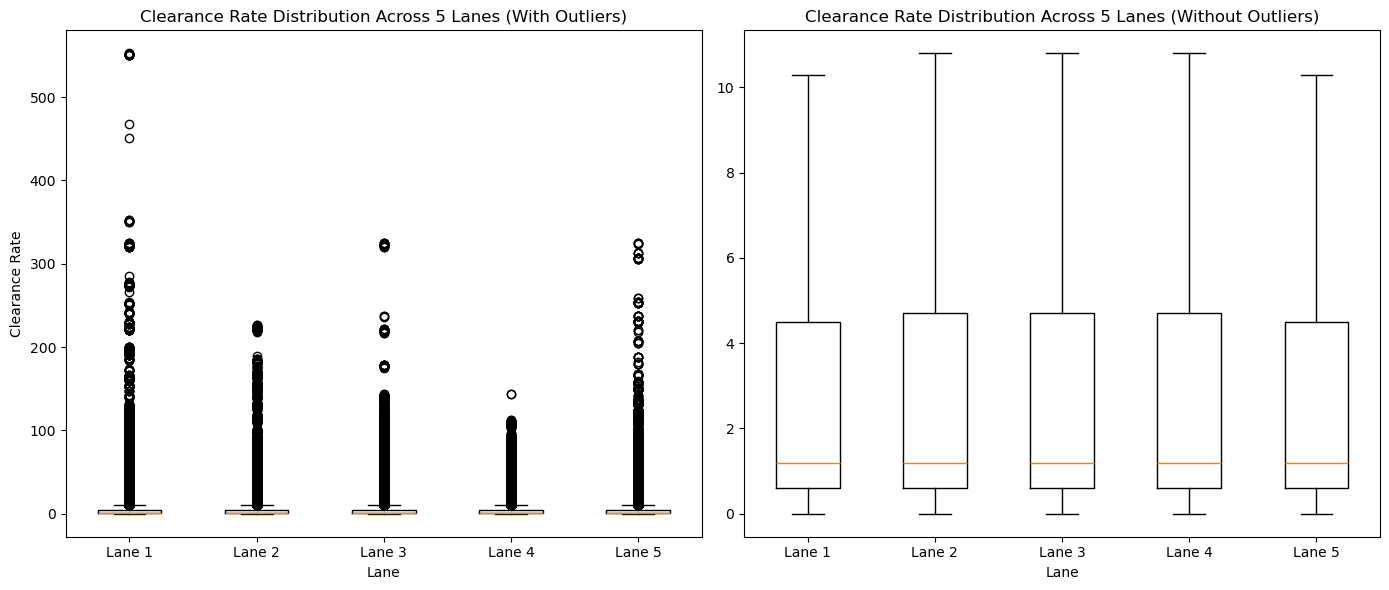

In [18]:
util.plot_clearance_rate_boxplots(log_file=file_name)

## Reward Shaping Method

- Apply reward (150 * new clearance rate) to good lane switch
- Apply penalty to impossible lane switch (switch left when lane = 1 and switch right when lane = 5)

### Train Model

In [19]:
# Initialize and vectorize the environment
env = env_gym_rs2.TrafficEnvironment(reward_shaping_flag=True)
check_env(env, warn=True)
env.reset()
eval_env = Monitor(env_gym_rs2.TrafficEnvironment(reward_shaping_flag=False))

# Set up log directory
log_dir = "./logs/dqn_rs2_model/"
os.makedirs(log_dir + "best_model/", exist_ok=True)
os.makedirs(log_dir + "final_model/", exist_ok=True)

# Define the DQN model with MlpPolicy (a policy network that works well with continuous environments)
model = DQN(policy = "MlpPolicy",
            env = env, 
            verbose = 1,
           )

# Set up evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir + "best_model/",
    log_path=log_dir + "results/",
    eval_freq=1000,  # Evaluate the model every 1000 steps
    deterministic=True,
    render=False
)

total_timesteps = 50000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

# Save the final model
final_model_path = log_dir + "final_model"
model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Eval num_timesteps=1000, episode_reward=-8446.00 +/- 9999.63
Episode length: 1392.40 +/- 776.11
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 1.39e+03  |
|    mean_reward      | -8.45e+03 |
| rollout/            |           |
|    exploration_rate | 0.81      |
| time/               |           |
|    total_timesteps  | 1000      |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 374       |
|    n_updates        | 224       |
-----------------------------------
New best mean reward!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 328      |
|    ep_rew_mean      | 7.19e+04 |
|    exploration_rate | 0.751    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 222      |
|    time_elapsed     | 5        |
|   

### Test Model

In [20]:
# Load the best baseline model
log_dir = "./logs/dqn_rs2_model/"
model_path = log_dir + 'best_model/best_model.zip'
model = DQN.load(model_path)

# Create test environment
env_test = env_gym.TrafficEnvironment()

In [21]:
# Test the model
num_episodes = 1000
file_name = 'dqn_rs2_best_model_test_log.json'
rewards, timesteps = util.test_model(model=model, env=env_test, num_episodes=num_episodes, output_file=file_name)

Average reward of 1000 episodes is -4556.
Average timesteps of 1000 episodes is 852.


### Analysis of Model

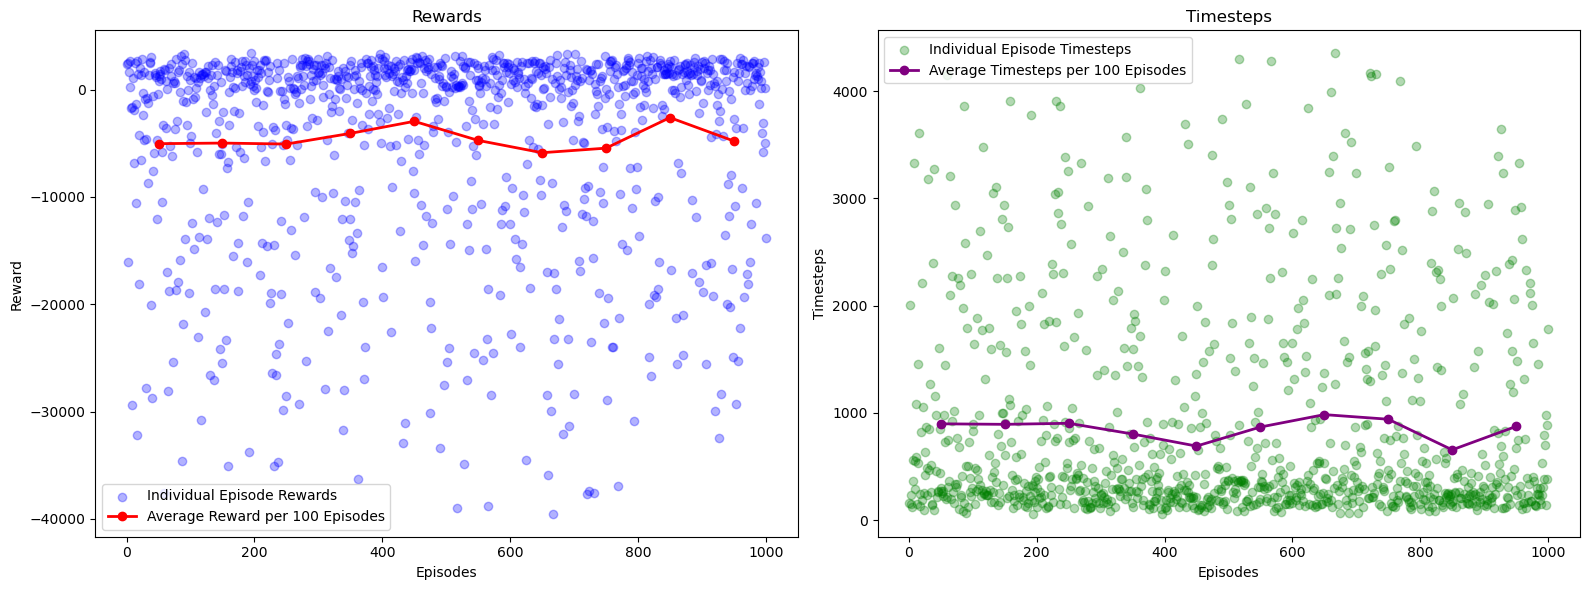

In [22]:
util.plot_test_dotplots(rewards=rewards, timesteps=timesteps, interval=100)

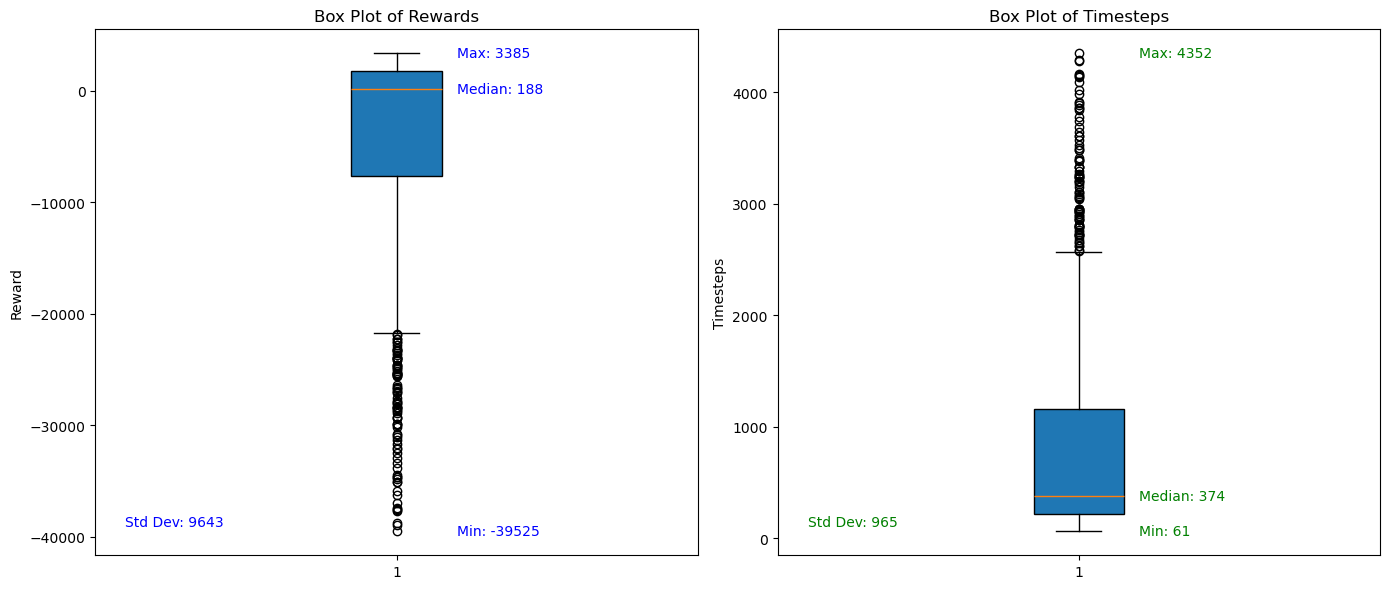

In [23]:
util.plot_test_boxplots(json_file=file_name)

In [24]:
util.calculate_action_percentages(log_file=file_name)
print("")
util.calculate_clearance_rate_percentages(log_file=file_name)

Total actions across 1000 episodes: 851798
Action -1: 0.2%
Action 0: 99.1%
Action 1: 0.7%

Total timesteps across 1000 episodes (including initial states): 852798
Lane 1:
  75.0% of timesteps had a clearance rate less than 5
  85.7% of timesteps had a clearance rate less than 10
Lane 2:
  74.6% of timesteps had a clearance rate less than 5
  85.6% of timesteps had a clearance rate less than 10
Lane 3:
  74.5% of timesteps had a clearance rate less than 5
  85.8% of timesteps had a clearance rate less than 10
Lane 4:
  74.6% of timesteps had a clearance rate less than 5
  86.0% of timesteps had a clearance rate less than 10
Lane 5:
  75.0% of timesteps had a clearance rate less than 5
  86.2% of timesteps had a clearance rate less than 10


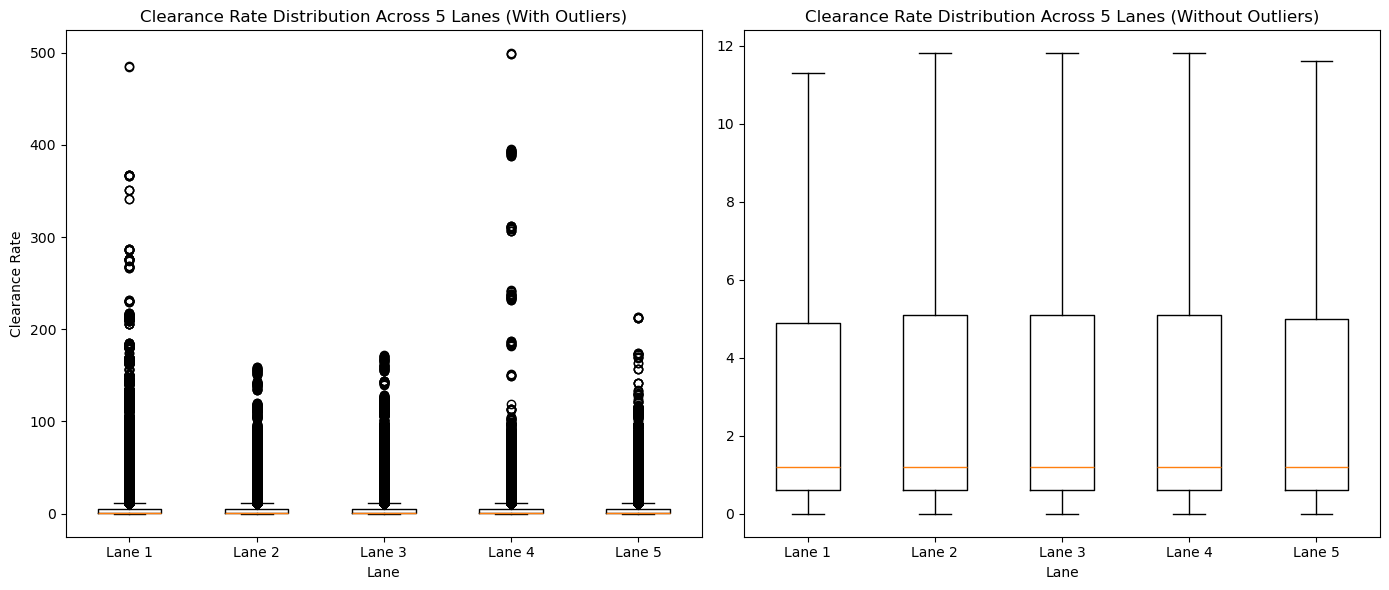

In [25]:
util.plot_clearance_rate_boxplots(log_file=file_name)

In [26]:
import optuna
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
import os

def optimize_dqn(trial):
    # Define hyperparameters to search
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    buffer_size = trial.suggest_categorical('buffer_size', [50000, 100000, 200000])
    learning_starts = trial.suggest_categorical('learning_starts', [1000, 5000, 10000])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    gamma = trial.suggest_float('gamma', 0.8, 0.999)
    
    # Initialize environment and wrap it for monitoring
    env = Monitor(env_gym_rs2.TrafficEnvironment(reward_shaping_flag=False))
    
    # Initialize the DQN model with suggested hyperparameters
    model = DQN(
        "MlpPolicy",
        env,
        learning_rate=learning_rate,
        buffer_size=buffer_size,
        learning_starts=learning_starts,
        batch_size=batch_size,
        gamma=gamma,
        verbose=0
    )
    
    # Train model for a fixed number of timesteps
    model.learn(total_timesteps=20000)
    
    # Evaluate the model and return the mean reward for optimization
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
    return mean_reward

# Set up Optuna study with early stopping
study = optuna.create_study(study_name="DQN_Optimization_rp", direction="maximize")


# Define an early stopping callback
def stop_early(study, trial):
    # Customize your early stopping condition here
    # For example, if the best trial reward surpasses 200, stop further trials
    if trial.number >= 10 and study.best_value > 200:
        return True
    return False

# Run the optimization with the early stopping callback
study.optimize(optimize_dqn, n_trials=50, callbacks=[stop_early])

# Display best parameters
print("Best hyperparameters:", study.best_params)

# Train a final model with the best parameters
best_params = study.best_params
final_env = Monitor(env_gym_rs2.TrafficEnvironment(reward_shaping_flag=False))

final_model = DQN(
    "MlpPolicy",
    final_env,
    **best_params,
    verbose=1
)

# Use the same evaluation callback as in your original code
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=log_dir + "best_model_rp_optuna/",
    log_path=log_dir + "results_rp_optuna/",
    eval_freq=1000,
    deterministic=True,
    render=False
)

# Train the model with optimized hyperparameters
final_model.learn(total_timesteps=total_timesteps, callback=eval_callback)

# Save the final model
final_model_path = log_dir + "final_model_rp_optuna"
final_model.save(final_model_path)
print(f"Final model saved to {final_model_path}")

[I 2024-11-16 15:50:05,224] A new study created in memory with name: DQN_Optimization_rp
[I 2024-11-16 15:50:41,779] Trial 0 finished with value: -4696.0 and parameters: {'learning_rate': 0.00866620223154016, 'buffer_size': 100000, 'learning_starts': 1000, 'batch_size': 32, 'gamma': 0.9987394896672577}. Best is trial 0 with value: -4696.0.
[I 2024-11-16 15:51:12,345] Trial 1 finished with value: -4162.0 and parameters: {'learning_rate': 0.0090151280270816, 'buffer_size': 100000, 'learning_starts': 5000, 'batch_size': 64, 'gamma': 0.9787168351661928}. Best is trial 1 with value: -4162.0.
[I 2024-11-16 15:51:43,056] Trial 2 finished with value: -7139.0 and parameters: {'learning_rate': 2.4280803889650886e-05, 'buffer_size': 200000, 'learning_starts': 5000, 'batch_size': 128, 'gamma': 0.973167317657609}. Best is trial 1 with value: -4162.0.
[I 2024-11-16 15:52:04,307] Trial 3 finished with value: 9.0 and parameters: {'learning_rate': 0.000414016982101944, 'buffer_size': 50000, 'learning_s

Best hyperparameters: {'learning_rate': 0.0027351304196241532, 'buffer_size': 50000, 'learning_starts': 5000, 'batch_size': 64, 'gamma': 0.8941551673847359}
Using cuda device
Wrapping the env in a DummyVecEnv.
Eval num_timesteps=1000, episode_reward=-10258.00 +/- 14372.85
Episode length: 570.40 +/- 574.87
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 570       |
|    mean_reward      | -1.03e+04 |
| rollout/            |           |
|    exploration_rate | 0.81      |
| time/               |           |
|    total_timesteps  | 1000      |
-----------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-13370.00 +/- 17346.41
Episode length: 694.80 +/- 693.86
-----------------------------------
| eval/               |           |
|    mean_ep_length   | 695       |
|    mean_reward      | -1.34e+04 |
| rollout/            |           |
|    exploration_rate | 0.62      |
| time/               |           

# Load the best optuna model
log_dir = "./logs/dqn_rs2_model/"
model_path = log_dir + 'final_model_rp_optuna.zip'
model = DQN.load(model_path)

# Create test environment
env_test = env_gym_rs2.TrafficEnvironment(reward_shaping_flag=False)

In [27]:
# Test the model
num_episodes = 1000
file_name = 'dqn_baseline_best_rp_optuna_model_test_log.json'
rewards, timesteps = util.test_model(model=model, env=env_test, num_episodes=num_episodes, output_file=file_name)

Average reward of 1000 episodes is -4752.
Average timesteps of 1000 episodes is 872.


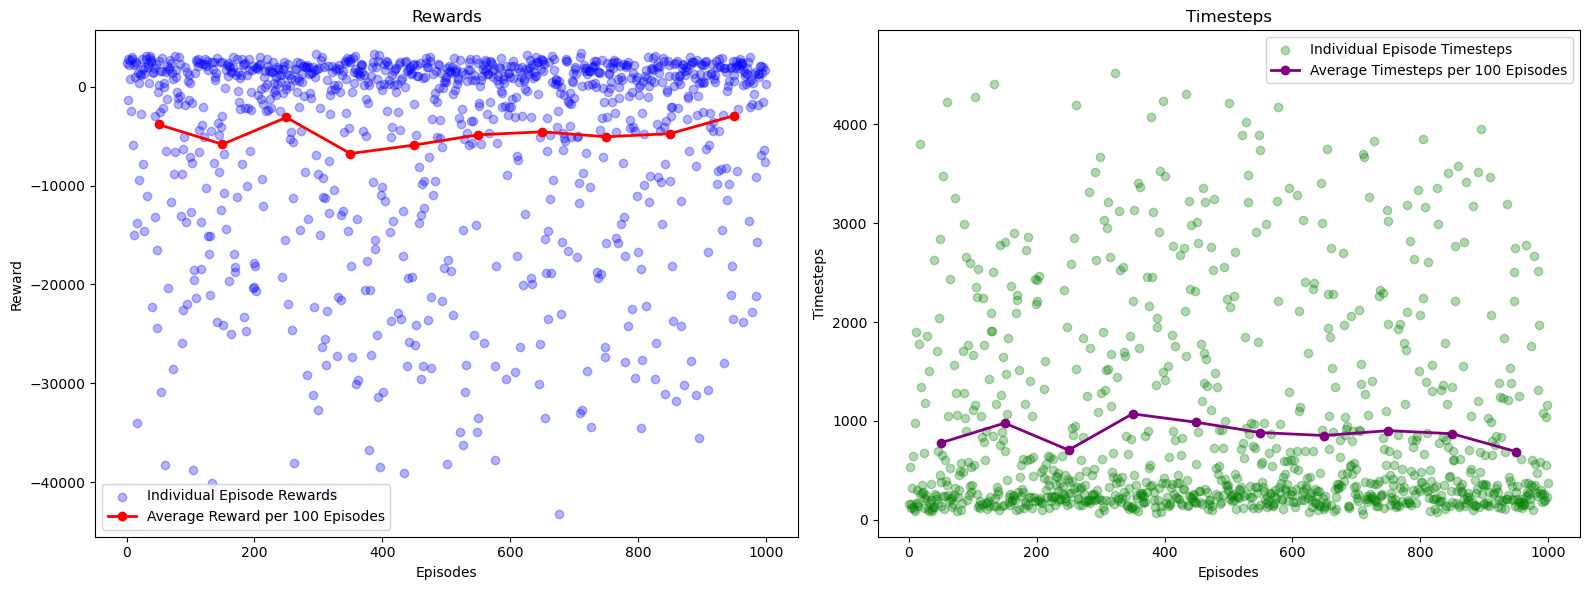

In [28]:
util.plot_test_dotplots(rewards=rewards, timesteps=timesteps, interval=100)

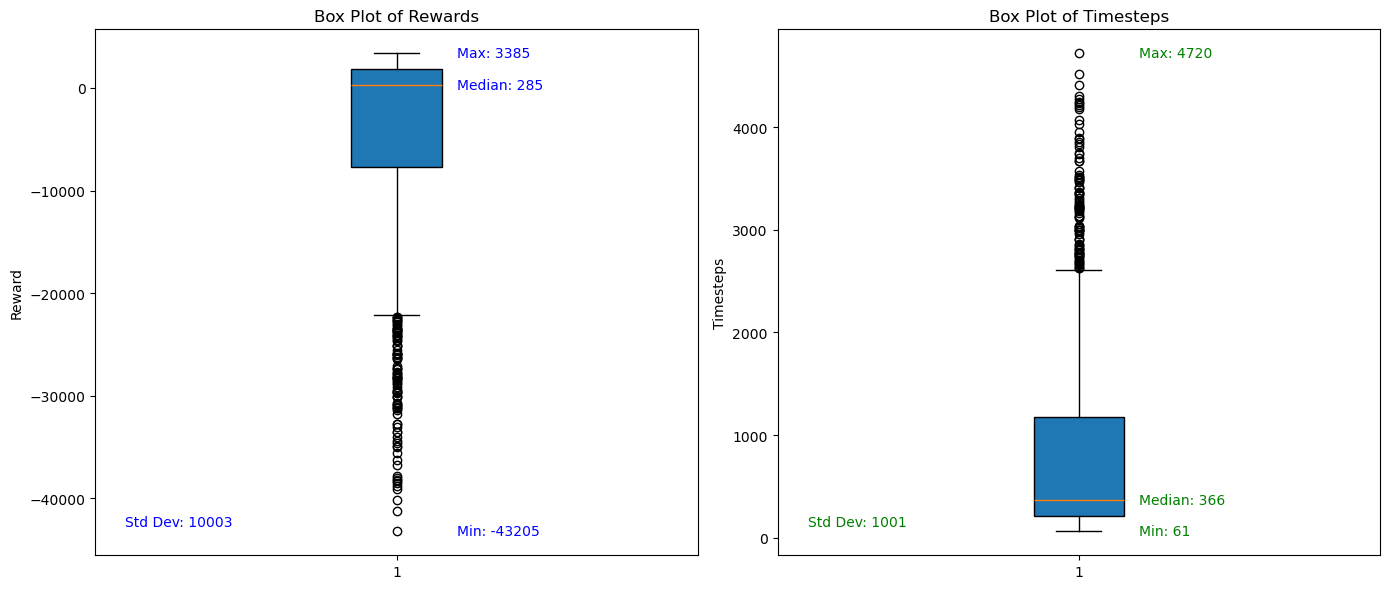

In [29]:
file_name = 'dqn_baseline_best_rp_optuna_model_test_log.json'
util.plot_test_boxplots(json_file=file_name)

In [30]:
util.calculate_action_percentages(log_file=file_name)

Total actions across 1000 episodes: 871580
Action -1: 0.2%
Action 0: 99.2%
Action 1: 0.6%


In [31]:
util.calculate_clearance_rate_percentages(log_file=file_name)

Total timesteps across 1000 episodes (including initial states): 872580
Lane 1:
  75.3% of timesteps had a clearance rate less than 5
  86.2% of timesteps had a clearance rate less than 10
Lane 2:
  75.0% of timesteps had a clearance rate less than 5
  86.1% of timesteps had a clearance rate less than 10
Lane 3:
  74.9% of timesteps had a clearance rate less than 5
  86.2% of timesteps had a clearance rate less than 10
Lane 4:
  75.1% of timesteps had a clearance rate less than 5
  86.4% of timesteps had a clearance rate less than 10
Lane 5:
  75.7% of timesteps had a clearance rate less than 5
  86.6% of timesteps had a clearance rate less than 10


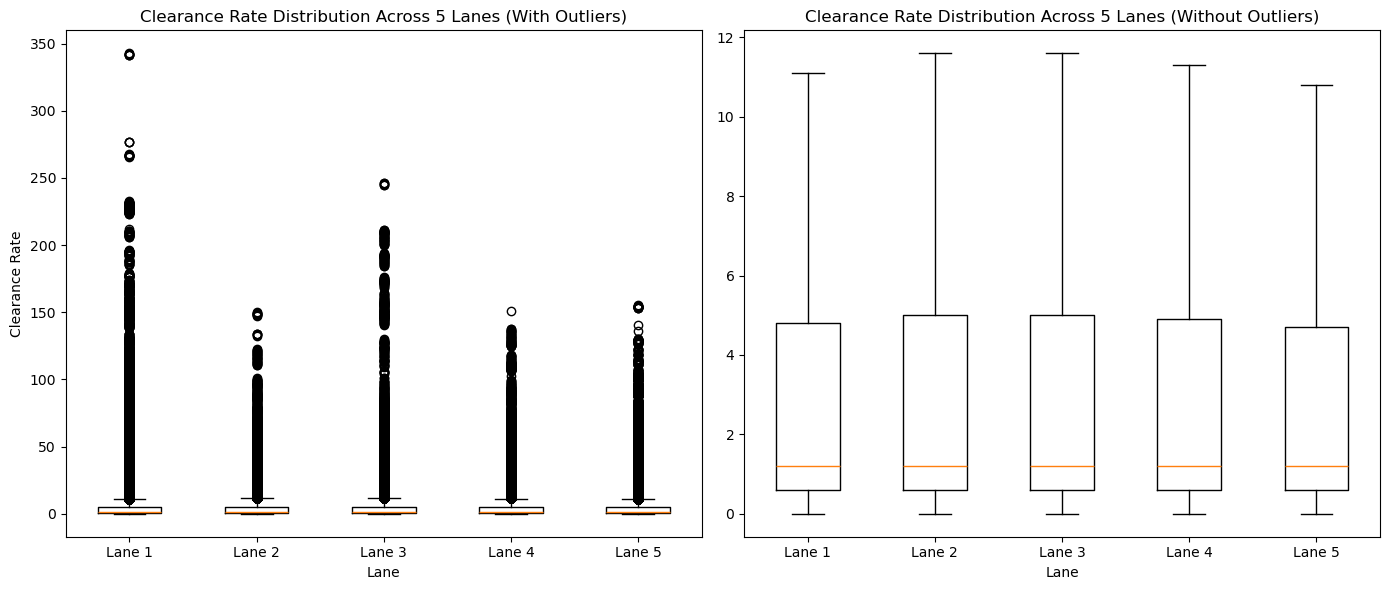

In [32]:
util.plot_clearance_rate_boxplots(log_file=file_name)